The Current working title is "Comparing the performance of pretained word2vec model with custom word2vec model on a standard tweet classification task.

In [1]:
!pip install gensim

In [2]:
import pandas
import numpy
import matplotlib.pyplot as plt
import re
import string
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from scipy.stats import norm
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import text_to_word_sequence, Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional, GRU, Input
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import pydot
import IPython
from IPython.display import SVG
from tensorflow.keras.utils import model_to_dot, plot_model

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train_data = pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/Tweet_Classifiaction/Corona_NLP_train.csv', encoding='latin1')
train_data.head()

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

Plotting a graph to see the distribution of classes.

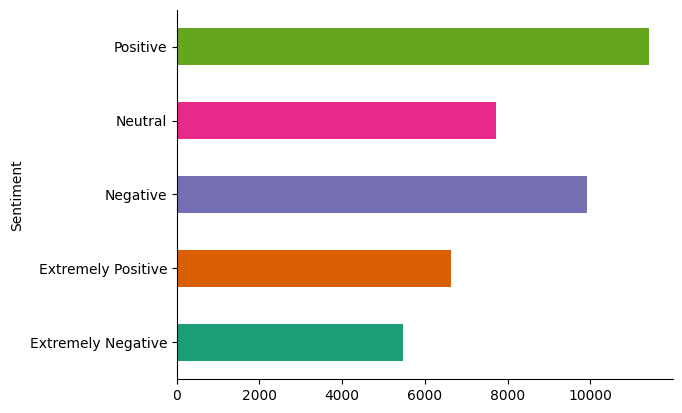

In [5]:
# @title Sentiment

from matplotlib import pyplot as plt
import seaborn as sns
train_data.groupby('Sentiment').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

The class distribution is uneven. Majority of the tweets belong to 'Postivie' class. However class distribution can be conisdered decent. This class distribution will not disrupt model building phase.

In this project the sentiment is predicted using only the original tweet. Rest of the columns are not used and therefore they are removed.

In [6]:
train_X = train_data['OriginalTweet']
train_y = train_data['Sentiment']

Next step is tokenization and all the columns are tokenized. Before tokenizing there is one other step. Tweets tag a person often using @ sign. Analysing how many tweets have @ signs.

In [7]:
train_data.shape

(41157, 6)

In [8]:
train_data['OriginalTweet'].str.contains('@').sum()

10035

In [9]:
# store as list of names
names = []
for n in train_X:
    names.append(n.translate(str.maketrans('', '', string.punctuation)))
# store as list of lists of words
names_tokens = []
for n in names:
    # break into tokens
    tokens = re.sub(r"[^a-z0-9]+", " ", n.lower()).split()
    names_tokens.append(tokens)

# have a look at the results
print(names_tokens)

Output hidden; open in https://colab.research.google.com to view.

First building the model with pre-trained model. The model used in this project is pretrained with google news dataset with approximately 2 million words.

More steps here to decide the max words before we move forward.

In [10]:
import gensim.downloader as api
wv = api.load('word2vec-google-news-300')

[==================================================] 100.0% 1662.8/1662.8MB downloaded


Before working on choosing maximum words that can be used in a single tweet it would be better to view at some stats regarding the length of the words.

In [11]:
len_tweet = []
for i in names_tokens:
    len_tweet.append(len(i))

In [12]:
mean = numpy.mean(len_tweet)
std = numpy.std(len_tweet)
max = numpy.max(len_tweet)
min = numpy.min(len_tweet)
print(mean, std, max, min)

30.37573195325218 11.65696459233426 64 1


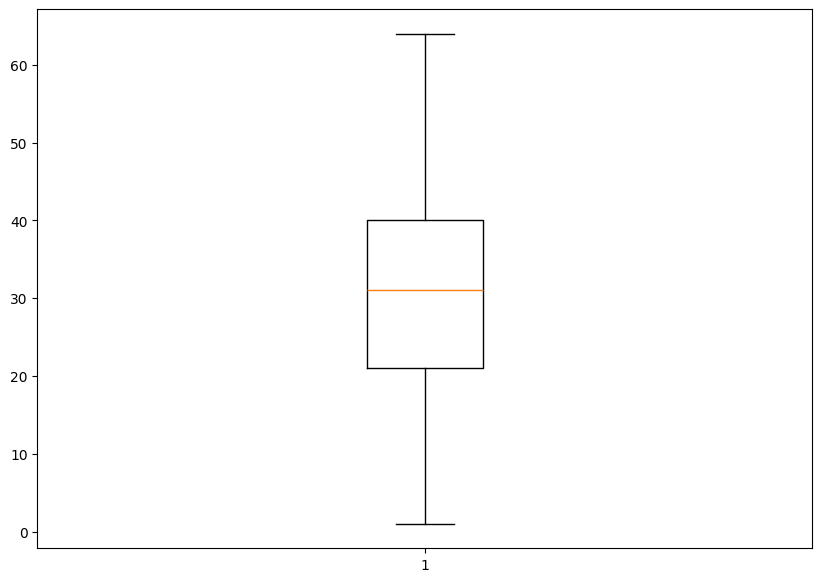

In [13]:
fig = plt.figure(figsize =(10, 7))
plt.boxplot(len_tweet)
plt.show()

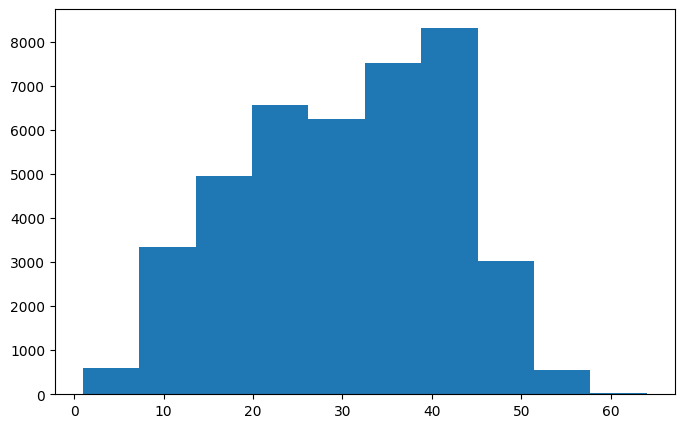

In [14]:
fig = plt.figure(figsize = (8, 5))
plt.hist(len_tweet, bins = 10)
plt.show()

Majority of tweets have over 20 words. Ideally, the maximum number of of words is considered and the rest of the data is padded. However this would make the the size of the embedding huge. Therefore for the sake of simplicity let us consider max_words = 10

## Baseline Model
Before creating a model with word2vec embeddings creating a model which utilizes the inbuilt embedding layer would provide a good baseline.

In [15]:
max_words = 50000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_X)
train_sequences = []
for seq in tokenizer.texts_to_sequences_generator(names_tokens):
    train_sequences.append(seq)
max_words = numpy.max(len_tweet)

train_padded_X = pad_sequences(train_sequences, maxlen=max_words, padding='post')

In [16]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the labels
Y_encoded = label_encoder.fit_transform(train_y)

# Now Y_wvp_encoded contains the label encoded values
Y_encoded

array([3, 4, 4, ..., 4, 3, 2])

In [17]:
train_X, val_X, train_y, val_y = train_test_split(train_padded_X, Y_encoded, test_size=0.2)

In [30]:
(train_X[1])

array([   79,  3348,    27,  4977,  1490,    83, 12412,   328,    48,
        8814,   139,  1729,   273,   105,   443,     9,   315,  1618,
          10,    80,    59,     1,    13,    12,    60,    26,    57,
           1, 11950,    15,  4810,     2,  1000,   124,    10,    66,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [18]:
model_0 = Sequential()
model_0.add(Embedding(50000, 300 , input_length=64))
model_0.add(LSTM(1024))
model_0.add(Dropout(0.5))
model_0.add(Dense(512, activation='relu'))
model_0.add(Dropout(0.5))
model_0.add(Dense(256, activation='relu'))
model_0.add(Dropout(0.5))
model_0.add(Dense(128, activation='relu'))
model_0.add(Dropout(0.5))
model_0.add(Dense(5, activation='softmax'))

model_0.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
print(model_0.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


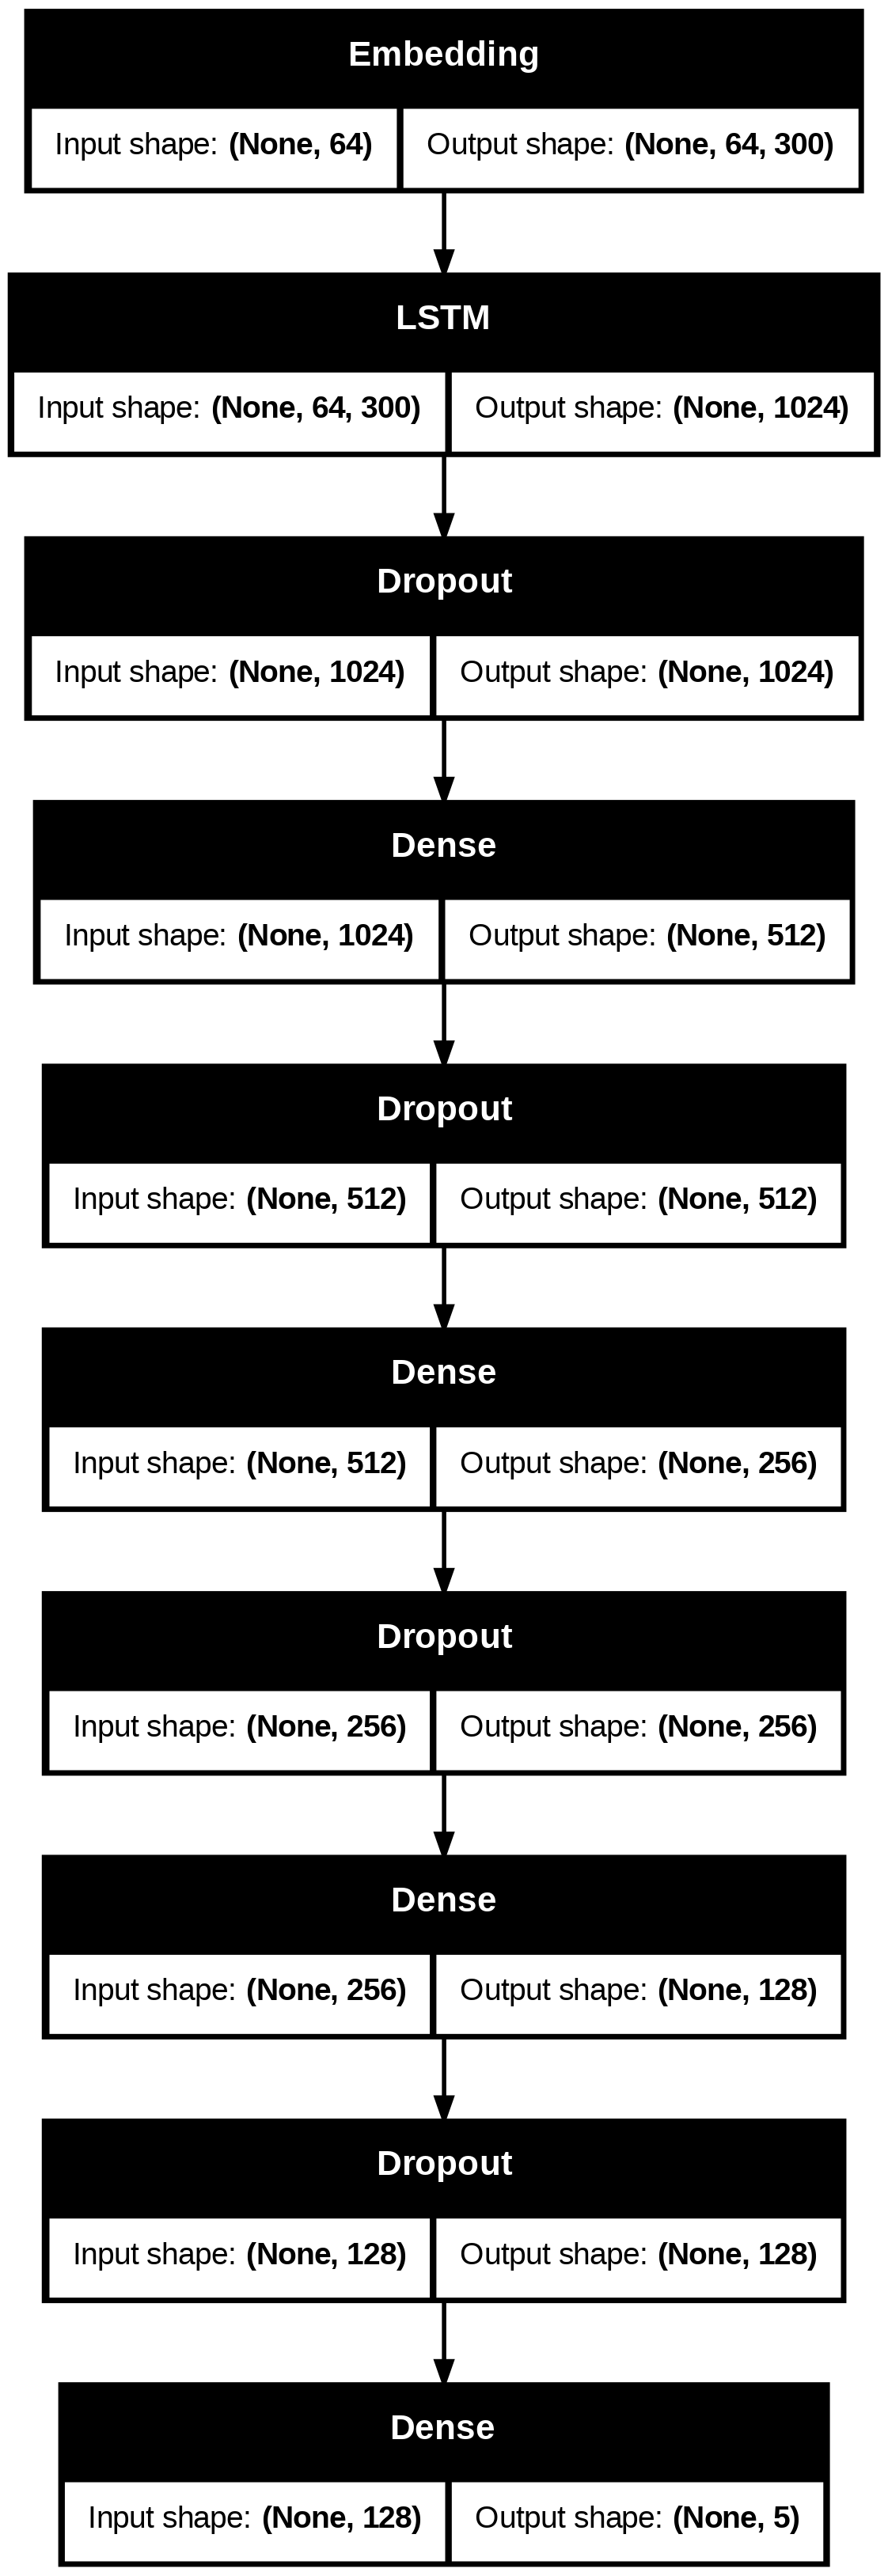

In [27]:
plot_model(model_0, show_shapes=True)

In [19]:
model_0.fit(train_X, train_y,
          batch_size=128,
          epochs=15,
          validation_data=[val_X, val_y])

Epoch 1/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 99ms/step - accuracy: 0.2678 - loss: 1.5855 - val_accuracy: 0.2717 - val_loss: 1.5808
Epoch 2/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 35s 100ms/step - accuracy: 0.2733 - loss: 1.5803 - val_accuracy: 0.2717 - val_loss: 1.5795
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 98ms/step - accuracy: 0.2770 - loss: 1.5770 - val_accuracy: 0.2717 - val_loss: 1.5794
Epoch 4/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 26s 100ms/step - accuracy: 0.2780 - loss: 1.5762 - val_accuracy: 0.2717 - val_loss: 1.5786
Epoch 5/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step - accuracy: 0.2657 - loss: 1.6048 - val_accuracy: 0.2717 - val_loss: 1.5809
Epoch 6/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 102ms/step - accuracy: 0.2809 - loss: 1.5768 - val_accuracy: 0.2717 - val_loss: 1.5801
Epoch 7/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 27s 105ms/step - accuracy: 0.2785 - loss: 1.5745 - val_accuracy: 0.2717 - val_loss: 1.5796
Epoch 8/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 26s 101ms/step - accuracy: 0.2795 - loss: 1.5

In [20]:
test_data = pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/Tweet_Classifiaction/Corona_NLP_test.csv', encoding='latin1')
test_data.head()
test_X = test_data['OriginalTweet']
test_y = test_data['Sentiment']

In [21]:
# store as list of names
names = []
for n in test_X:
    names.append(n.translate(str.maketrans('', '', string.punctuation)))
# store as list of lists of words
names_tokens = []
for n in names:
    # break into tokens
    tokens = re.sub(r"[^a-z0-9]+", " ", n.lower()).split()
    names_tokens.append(tokens)


In [22]:
test_sequences = []
for seq in tokenizer.texts_to_sequences_generator(names_tokens):
    test_sequences.append(seq)

In [23]:
max_words = numpy.max(len_tweet)

test_padded_X = pad_sequences(test_sequences, maxlen=max_words, padding='post')

In [24]:
# Fit and transform the labels
Y_test_encoded = label_encoder.fit_transform(test_y)

# Now Y_test_encoded contains the label encoded values
Y_test_encoded


array([0, 4, 1, ..., 3, 0, 1])

In [25]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(y_true, y_pred):
    """
    Evaluates a multi-class classification model.

    Parameters:
        y_true (numpy array or list): True labels (shape: [num_samples, ])
        y_pred (numpy array or list): Predicted labels (shape: [num_samples, ])

    Prints:
        - Overall Accuracy
        - Precision, Recall, and F1-score per class
    """
    # Compute overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Compute precision, recall, F1-score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

    # Print results for each class
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        print(f"Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1-score = {f:.4f}")

    return accuracy, precision, recall, f1

In [26]:
y_pred_prob = model_0.predict(test_padded_X)  # Shape: (num_samples, num_classes)

# Convert to class labels (select highest probability)
y_pred = numpy.argmax(y_pred_prob, axis=1)

# Evaluate the model
evaluate_model(Y_test_encoded, y_pred)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step
Overall Accuracy: 0.2493
Class 0: Precision = 0.0000, Recall = 0.0000, F1-score = 0.0000
Class 1: Precision = 0.0000, Recall = 0.0000, F1-score = 0.0000
Class 2: Precision = 0.0000, Recall = 0.0000, F1-score = 0.0000
Class 3: Precision = 0.0000, Recall = 0.0000, F1-score = 0.0000
Class 4: Precision = 0.2493, Recall = 1.0000, F1-score = 0.3992


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.2493417588204318,
 array([0.        , 0.        , 0.        , 0.        , 0.24934176]),
 array([0., 0., 0., 0., 1.]),
 array([0.        , 0.        , 0.        , 0.        , 0.39915701]))

## Word2Vec Pretrained model.
Creating the word2vec pretrained model.

In [35]:
train_X = train_data['OriginalTweet']
train_y = train_data['Sentiment']

In [36]:
# store as list of names
names = []
for n in train_X:
    names.append(n.translate(str.maketrans('', '', string.punctuation)))
# store as list of lists of words
names_tokens = []
for n in names:
    # break into tokens
    tokens = re.sub(r"[^a-z0-9]+", " ", n.lower()).split()
    names_tokens.append(tokens)

# have a look at the results
print(names_tokens)

Output hidden; open in https://colab.research.google.com to view.

In [37]:
X = []
Y = []
for i,n in enumerate(names_tokens):
    tweet = []
    for j,w in enumerate(n):
      try:
         x = wv[w]
         tweet.append(w)
      except:
        pass
    X.append(tweet)
    Y.append(train_y[i])

In [42]:
max_words = 50000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)

In [43]:
train_sequences = []
for seq in tokenizer.texts_to_sequences_generator(X):
    train_sequences.append(seq)

In [44]:
max_words = numpy.max(len_tweet)

train_padded_X = pad_sequences(train_sequences, maxlen=max_words, padding='post')

In [45]:
train_padded_X[100]

array([    7,  2151,    20,    43,     2,   768,    45,     7,  4278,
           7,   166,   179,    18,    46,   235,   162,    34,    30,
         526,    16,     1, 16820,    63,   757,    12,    27,     3,
         848,  2392,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0,     0,     0,     0,     0,     0,     0,     0,     0,
           0], dtype=int32)

In [46]:
embedding_matrix = numpy.zeros((50000, 300))
word_index = tokenizer.word_index
# Fill embedding matrix with Word2Vec vectors
for word, i in word_index.items():
    if i < 50000:  # Keep within vocab size limit
        embedding_matrix[i] = wv[word]

In [47]:
model = Sequential()
model.add(Embedding(input_dim=50000, output_dim=300,
              weights=[embedding_matrix], input_length=64, trainable=False))
model.add(LSTM(1024))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='softmax'))

model.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │      15,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_24 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,000,000 (57.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,000,000 (57.22 MB)

None


In [48]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the labels
Y_wvp_encoded = label_encoder.fit_transform(Y)

# Now Y_wvp_encoded contains the label encoded values
Y_wvp_encoded


array([3, 4, 4, ..., 4, 3, 2])

In [49]:
train_X, val_X, train_y, val_y = train_test_split(train_padded_X, Y_wvp_encoded, test_size=0.2)
print(len(train_X))
print(len(train_y))
print(len(val_X))
print(len(val_y))

32925
32925
8232
8232


In [50]:
model.fit(train_X, train_y,
          batch_size=128,
          epochs=15,
          validation_data=[val_X, val_y])

Epoch 1/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - accuracy: 0.2732 - loss: 1.5994 - val_accuracy: 0.2716 - val_loss: 1.5631
Epoch 2/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 39s 102ms/step - accuracy: 0.3000 - loss: 1.4996 - val_accuracy: 0.3693 - val_loss: 1.3566
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 42s 104ms/step - accuracy: 0.3739 - loss: 1.3755 - val_accuracy: 0.3794 - val_loss: 1.3162
Epoch 4/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 102ms/step - accuracy: 0.4554 - loss: 1.2613 - val_accuracy: 0.6102 - val_loss: 1.0042
Epoch 5/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 42s 105ms/step - accuracy: 0.6127 - loss: 0.9978 - val_accuracy: 0.6499 - val_loss: 0.9056
Epoch 6/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.6596 - loss: 0.9065 - val_accuracy: 0.6791 - val_loss: 0.8554
Epoch 7/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.6996 - loss: 0.8211 - val_accuracy: 0.7173 - val_loss: 0.7683
Epoch 8/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.7273 - loss: 0

## Test Data

In [51]:
test_data = pandas.read_csv('/content/drive/MyDrive/Colab Notebooks/Tweet_Classifiaction/Corona_NLP_test.csv', encoding='latin1')
test_data.head()

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   

                                       OriginalTweet           Sentiment  
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative  
1  When I couldn't find hand sanitizer at Fred Me...            Positive  
2  Find out how you can protect yourself and love...  Extremely Positive  
3  #Panic buying hits #NewYork City as anxious sh...            Negative  
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral

In [52]:
test_X = test_data['OriginalTweet']
test_y = test_data['Sentiment']

In [53]:
# store as list of names
names = []
for n in test_X:
    names.append(n.translate(str.maketrans('', '', string.punctuation)))
# store as list of lists of words
names_tokens = []
for n in names:
    # break into tokens
    tokens = re.sub(r"[^a-z0-9]+", " ", n.lower()).split()
    names_tokens.append(tokens)


In [54]:
# have a look at the results
print(names_tokens)
X = []
Y = []
for i,n in enumerate(names_tokens):
    tweet = []
    for j,w in enumerate(n):
      try:
         x = wv[w]
         tweet.append(w)
      except:
        pass
    X.append(tweet)
    Y.append(test_y[i])

[['trending', 'new', 'yorkers', 'encounter', 'empty', 'supermarket', 'shelves', 'pictured', 'wegmans', 'in', 'brooklyn', 'soldout', 'online', 'grocers', 'foodkick', 'maxdelivery', 'as', 'coronavirusfearing', 'shoppers', 'stock', 'up', 'httpstcogr76pcrlwh', 'httpstcoivmkmsqdt1'], ['when', 'i', 'couldnt', 'find', 'hand', 'sanitizer', 'at', 'fred', 'meyer', 'i', 'turned', 'to', 'amazon', 'but', '11497', 'for', 'a', '2', 'pack', 'of', 'purellcheck', 'out', 'how', 'coronavirus', 'concerns', 'are', 'driving', 'up', 'prices', 'httpstcoygbipbflmy'], ['find', 'out', 'how', 'you', 'can', 'protect', 'yourself', 'and', 'loved', 'ones', 'from', 'coronavirus'], ['panic', 'buying', 'hits', 'newyork', 'city', 'as', 'anxious', 'shoppers', 'stock', 'up', 'on', 'foodampmedical', 'supplies', 'after', 'healthcare', 'worker', 'in', 'her', '30s', 'becomes', 'bigapple', '1st', 'confirmed', 'coronavirus', 'patient', 'or', 'a', 'bloomberg', 'staged', 'event', 'httpstcoiasiregpc4', 'qanon', 'qanon2018', 'qanon20

In [55]:
test_sequences = []
for seq in tokenizer.texts_to_sequences_generator(X):
    test_sequences.append(seq)

In [56]:
max_words = numpy.max(len_tweet)

test_padded_X = pad_sequences(test_sequences, maxlen=max_words, padding='post')

In [57]:
# Fit and transform the labels
Y_test_encoded = label_encoder.fit_transform(Y)

# Now Y_test_encoded contains the label encoded values
Y_test_encoded


array([0, 4, 1, ..., 3, 0, 1])

In [58]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def evaluate_model(y_true, y_pred):
    """
    Evaluates a multi-class classification model.

    Parameters:
        y_true (numpy array or list): True labels (shape: [num_samples, ])
        y_pred (numpy array or list): Predicted labels (shape: [num_samples, ])

    Prints:
        - Overall Accuracy
        - Precision, Recall, and F1-score per class
    """
    # Compute overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"Overall Accuracy: {accuracy:.4f}")

    # Compute precision, recall, F1-score for each class
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average=None)

    # Print results for each class
    for i, (p, r, f) in enumerate(zip(precision, recall, f1)):
        print(f"Class {i}: Precision = {p:.4f}, Recall = {r:.4f}, F1-score = {f:.4f}")

    return accuracy, precision, recall, f1

In [59]:
y_pred_prob = model.predict(test_padded_X)  # Shape: (num_samples, num_classes)

# Convert to class labels (select highest probability)
y_pred = numpy.argmax(y_pred_prob, axis=1)

# Evaluate the model
evaluate_model(Y_test_encoded, y_pred)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Overall Accuracy: 0.7162
Class 0: Precision = 0.8121, Recall = 0.6791, F1-score = 0.7397
Class 1: Precision = 0.8361, Recall = 0.6644, F1-score = 0.7405
Class 2: Precision = 0.6529, Recall = 0.7426, F1-score = 0.6948
Class 3: Precision = 0.8425, Recall = 0.7431, F1-score = 0.7897
Class 4: Precision = 0.6263, Recall = 0.7254, F1-score = 0.6722


(0.7161664033701949,
 array([0.81212121, 0.83613445, 0.65287162, 0.84249084, 0.62625342]),
 array([0.67905405, 0.66444073, 0.74255524, 0.74313409, 0.72544879]),
 array([0.73965041, 0.74046512, 0.69483146, 0.78969957, 0.67221135]))

## Bidirectional LSTM

In [60]:
# The Bidirectional LSTM model is model_1
model_1 = Sequential()
model_1.add(Embedding(input_dim=50000, output_dim=300,
              weights=[embedding_matrix], input_length=64, trainable=False))
model_1.add(Bidirectional(LSTM(1024)))
model_1.add(Dropout(0.5))
model_1.add(Dense(512, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(256, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(128, activation='relu'))
model_1.add(Dropout(0.5))
model_1.add(Dense(5, activation='softmax'))

model_1.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_7 (Embedding)              │ ?                           │      15,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_28 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_29 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_30 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_30 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_31 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_31 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,000,000 (57.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,000,000 (57.22 MB)

None


In [61]:
model_1.fit(train_X, train_y,
          batch_size=128,
          epochs=15,
          validation_data=[val_X, val_y])

Epoch 1/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 60s 209ms/step - accuracy: 0.2998 - loss: 1.5360 - val_accuracy: 0.4463 - val_loss: 1.2609
Epoch 2/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 81s 205ms/step - accuracy: 0.4887 - loss: 1.2067 - val_accuracy: 0.5366 - val_loss: 1.0969
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 82s 205ms/step - accuracy: 0.5608 - loss: 1.0774 - val_accuracy: 0.6139 - val_loss: 0.9759
Epoch 4/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 83s 210ms/step - accuracy: 0.6174 - loss: 0.9718 - val_accuracy: 0.6337 - val_loss: 0.9195
Epoch 5/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 81s 205ms/step - accuracy: 0.6476 - loss: 0.9109 - val_accuracy: 0.6449 - val_loss: 0.9058
Epoch 6/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 52s 203ms/step - accuracy: 0.6747 - loss: 0.8447 - val_accuracy: 0.6675 - val_loss: 0.8505
Epoch 7/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 54s 208ms/step - accuracy: 0.6997 - loss: 0.7890 - val_accuracy: 0.6848 - val_loss: 0.8314
Epoch 8/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 82s 206ms/step - accuracy: 0.7168 - loss: 0

In [62]:
y_pred_prob = model_1.predict(test_padded_X)  # Shape: (num_samples, num_classes)

# Convert to class labels (select highest probability)
y_pred = numpy.argmax(y_pred_prob, axis=1)

# Evaluate the model
evaluate_model(Y_test_encoded, y_pred)

119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Overall Accuracy: 0.6877
Class 0: Precision = 0.7942, Recall = 0.6064, F1-score = 0.6877
Class 1: Precision = 0.7715, Recall = 0.7329, F1-score = 0.7517
Class 2: Precision = 0.6233, Recall = 0.6897, F1-score = 0.6548
Class 3: Precision = 0.7722, Recall = 0.7447, F1-score = 0.7582
Class 4: Precision = 0.6177, Recall = 0.6705, F1-score = 0.6430


(0.6877303844128488,
 array([0.79424779, 0.771529  , 0.62326389, 0.7721943 , 0.61770428]),
 array([0.60641892, 0.73288815, 0.68972142, 0.7447496 , 0.67053854]),
 array([0.68773946, 0.75171233, 0.65481076, 0.75822368, 0.64303797]))

## GRU

In [67]:
# The GRU model is model_2
model_2 = Sequential()
model_2.add(Embedding(input_dim=50000, output_dim=300,
              weights=[embedding_matrix], input_length=64, trainable=False))
model_2.add(GRU(1024))
model_2.add(Dropout(0.5))
model_2.add(Dense(512, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(256, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(128, activation='relu'))
model_2.add(Dropout(0.5))
model_2.add(Dense(5, activation='softmax'))

model_2.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
print(model_2.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ ?                           │      15,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru (GRU)                            │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_12 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,000,000 (57.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,000,000 (57.22 MB)

None


In [68]:
model_2.fit(train_X, train_y,
          batch_size=128,
          epochs=15,
          validation_data=[val_X, val_y])

Epoch 1/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 27s 88ms/step - accuracy: 0.2712 - loss: 1.5837 - val_accuracy: 0.2408 - val_loss: 1.5774
Epoch 2/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.2735 - loss: 1.5786 - val_accuracy: 0.2807 - val_loss: 1.5744
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 82ms/step - accuracy: 0.2743 - loss: 1.5787 - val_accuracy: 0.2807 - val_loss: 1.5718
Epoch 4/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 43s 88ms/step - accuracy: 0.2734 - loss: 1.5775 - val_accuracy: 0.2807 - val_loss: 1.5733
Epoch 5/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 86ms/step - accuracy: 0.2796 - loss: 1.5765 - val_accuracy: 0.2807 - val_loss: 1.5728
Epoch 6/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.2763 - loss: 1.5776 - val_accuracy: 0.2807 - val_loss: 1.5720
Epoch 7/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 84ms/step - accuracy: 0.2713 - loss: 1.5865 - val_accuracy: 0.2807 - val_loss: 1.5796
Epoch 8/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 41s 85ms/step - accuracy: 0.2731 - loss: 1.5803 - 

In [69]:
y_pred_prob = model_2.predict(test_padded_X)  # Shape: (num_samples, num_classes)

# Convert to class labels (select highest probability)
y_pred = numpy.argmax(y_pred_prob, axis=1)

# Evaluate the model
evaluate_model(Y_test_encoded, y_pred)

119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
Overall Accuracy: 0.2709
Class 0: Precision = 0.0000, Recall = 0.0000, F1-score = 0.0000
Class 1: Precision = 0.0000, Recall = 0.0000, F1-score = 0.0000
Class 2: Precision = 0.0000, Recall = 0.0000, F1-score = 0.0000
Class 3: Precision = 0.7192, Recall = 0.1696, F1-score = 0.2745
Class 4: Precision = 0.2530, Recall = 0.9757, F1-score = 0.4018


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.27093206951026855,
 array([0.        , 0.        , 0.        , 0.71917808, 0.25301205]),
 array([0.        , 0.        , 0.        , 0.16962843, 0.97571278]),
 array([0.        , 0.        , 0.        , 0.2745098 , 0.40182648]))

## Bidirectional GRU

In [70]:
# The Bidirectional GRU model is model_3
model_3 = Sequential()
model_3.add(Embedding(input_dim=50000, output_dim=300,
              weights=[embedding_matrix], input_length=64, trainable=False))
model_3.add(Bidirectional(GRU(1024)))
model_3.add(Dropout(0.5))
model_3.add(Dense(512, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(256, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(128, activation='relu'))
model_3.add(Dropout(0.5))
model_3.add(Dense(5, activation='softmax'))

model_3.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
print(model_3.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_4 (Embedding)              │ ?                           │      15,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_16 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_17 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_18 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_18 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_19 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_19 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,000,000 (57.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,000,000 (57.22 MB)

None


In [71]:
model_3.fit(train_X, train_y,
          batch_size=128,
          epochs=15,
          validation_data=[val_X, val_y])

Epoch 1/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 53s 171ms/step - accuracy: 0.2799 - loss: 1.5616 - val_accuracy: 0.4227 - val_loss: 1.4074
Epoch 2/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 43s 167ms/step - accuracy: 0.4934 - loss: 1.1906 - val_accuracy: 0.5456 - val_loss: 1.0845
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 43s 166ms/step - accuracy: 0.5841 - loss: 1.0335 - val_accuracy: 0.6282 - val_loss: 0.9253
Epoch 4/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 84s 175ms/step - accuracy: 0.6358 - loss: 0.9275 - val_accuracy: 0.6610 - val_loss: 0.8695
Epoch 5/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 82s 174ms/step - accuracy: 0.6697 - loss: 0.8608 - val_accuracy: 0.6777 - val_loss: 0.8307
Epoch 6/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - accuracy: 0.7008 - loss: 0.7861 - val_accuracy: 0.6804 - val_loss: 0.8266
Epoch 7/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 82s 174ms/step - accuracy: 0.7316 - loss: 0.7155 - val_accuracy: 0.6802 - val_loss: 0.8220
Epoch 8/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - accuracy: 0.7613 - loss: 0

In [72]:
y_pred_prob = model_3.predict(test_padded_X)  # Shape: (num_samples, num_classes)

# Convert to class labels (select highest probability)
y_pred = numpy.argmax(y_pred_prob, axis=1)

# Evaluate the model
evaluate_model(Y_test_encoded, y_pred)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
Overall Accuracy: 0.6761
Class 0: Precision = 0.7540, Recall = 0.6368, F1-score = 0.6905
Class 1: Precision = 0.7585, Recall = 0.7078, F1-score = 0.7323
Class 2: Precision = 0.6227, Recall = 0.6580, F1-score = 0.6399
Class 3: Precision = 0.8247, Recall = 0.6914, F1-score = 0.7522
Class 4: Precision = 0.5839, Recall = 0.6906, F1-score = 0.6328


(0.6761453396524486,
 array([0.754     , 0.75849732, 0.62272727, 0.82466281, 0.58392857]),
 array([0.63682432, 0.70784641, 0.65802113, 0.6914378 , 0.6906019 ]),
 array([0.69047619, 0.73229706, 0.6398879 , 0.75219684, 0.63280116]))

## Building a Custom Word2Vec model.

In [7]:
train_X = train_data['OriginalTweet']
train_y = train_data['Sentiment']

In [10]:
test_X = test_data['OriginalTweet']
test_y = test_data['Sentiment']

Training the word2vec model on the entire available corpus would be ideal for training.

In [11]:
# store as list of names
names = []
for n in train_X:
    names.append(n.translate(str.maketrans('', '', string.punctuation)))
# store as list of lists of words
for n in test_X:
    names.append(n.translate(str.maketrans('', '', string.punctuation)))

names_tokens = []
for n in names:
    # break into tokens
    tokens = re.sub(r"[^a-z0-9]+", " ", n.lower()).split()
    names_tokens.append(tokens)

# have a look at the results
print(names_tokens)

Output hidden; open in https://colab.research.google.com to view.

In [12]:
embedding_size = 300 # The embedding size is kept the same
# The min_count is kept to 1.

word_model = Word2Vec(sentences=names_tokens, vector_size=embedding_size, window=5, min_count=2, workers=4, sg=0)

In [13]:
names = []
for n in train_X:
    names.append(n.translate(str.maketrans('', '', string.punctuation)))
# store as list of lists of words
names_tokens = []
for n in names:
    # break into tokens
    tokens = re.sub(r"[^a-z0-9]+", " ", n.lower()).split()
    names_tokens.append(tokens)

# have a look at the results
print(names_tokens)

Output hidden; open in https://colab.research.google.com to view.

In [14]:
X = []
Y = []
i =0
for i,n in enumerate(names_tokens):
    tweet = []
    for j,w in enumerate(n):
      try:
         x = word_model.wv[w]
         tweet.append(w)
      except:
        pass
    X.append(tweet)
    Y.append(train_y[i])

In [15]:
max_words = 50000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)

In [18]:
train_sequences = []
for seq in tokenizer.texts_to_sequences_generator(X):
    train_sequences.append(seq)

max_words = numpy.max(len_tweet)
train_padded_X = pad_sequences(train_sequences, maxlen= max_words, padding='post')

In [19]:
embedding_matrix = numpy.zeros((50000, 300))
word_index = tokenizer.word_index
# Fill embedding matrix with Word2Vec vectors
for word, i in word_index.items():
    if i < 50000:  # Keep within vocab size limit
        embedding_matrix[i] = word_model.wv[word]

In [20]:
model_4 = Sequential()
model_4.add(Embedding(input_dim=50000, output_dim=300,
              weights=[embedding_matrix], input_length=64, trainable=False))
model_4.add(LSTM(1024))
model_4.add(Dropout(0.5))
model_4.add(Dense(512, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(256, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(128, activation='relu'))
model_4.add(Dropout(0.5))
model_4.add(Dense(5, activation='softmax'))

model_4.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
print(model_4.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │      15,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,000,000 (57.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,000,000 (57.22 MB)

None


In [21]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the labels
Y_wvp_encoded = label_encoder.fit_transform(Y)

# Now Y_wvp_encoded contains the label encoded values
Y_wvp_encoded


array([3, 4, 4, ..., 4, 3, 2])

In [22]:
train_X, val_X, train_y, val_y = train_test_split(train_padded_X, Y_wvp_encoded, test_size=0.2)
print(len(train_X))
print(len(train_y))
print(len(val_X))
print(len(val_y))

32925
32925
8232
8232


In [23]:
model_4.fit(train_X, train_y,
          batch_size=128,
          epochs=15,
          validation_data=[val_X, val_y])

Epoch 1/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 31s 92ms/step - accuracy: 0.2654 - loss: 1.5735 - val_accuracy: 0.2886 - val_loss: 1.5247
Epoch 2/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 39s 95ms/step - accuracy: 0.3219 - loss: 1.4979 - val_accuracy: 0.3752 - val_loss: 1.4094
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 42s 99ms/step - accuracy: 0.3849 - loss: 1.3813 - val_accuracy: 0.4462 - val_loss: 1.2860
Epoch 4/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 42s 103ms/step - accuracy: 0.4542 - loss: 1.2800 - val_accuracy: 0.4996 - val_loss: 1.2049
Epoch 5/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 29s 112ms/step - accuracy: 0.5061 - loss: 1.1909 - val_accuracy: 0.5284 - val_loss: 1.1619
Epoch 6/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.5393 - loss: 1.1334 - val_accuracy: 0.5502 - val_loss: 1.1096
Epoch 7/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 28s 110ms/step - accuracy: 0.5732 - loss: 1.0667 - val_accuracy: 0.5502 - val_loss: 1.0888
Epoch 8/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step - accuracy: 0.6144 - loss: 0.97

In [33]:
test_X = test_data['OriginalTweet']
test_y = test_data['Sentiment']

In [34]:
# store as list of names
names = []
for n in test_X:
    names.append(n.translate(str.maketrans('', '', string.punctuation)))
# store as list of lists of words
names_tokens = []
for n in names:
    # break into tokens
    tokens = re.sub(r"[^a-z0-9]+", " ", n.lower()).split()
    names_tokens.append(tokens)

In [35]:
max_words = 15
X = []
Y = []
i =0
for i,n in enumerate(names_tokens):
    tweet = []
    for j,w in enumerate(n):
      try:
         x = word_model.wv[w]
         tweet.append(w)
      except:
        pass
    X.append(tweet)
    Y.append(train_y[i])

In [36]:
test_sequences = []
for seq in tokenizer.texts_to_sequences_generator(X):
    test_sequences.append(seq)

In [37]:
max_words = numpy.max(len_tweet)

test_padded_X = pad_sequences(test_sequences, maxlen=max_words, padding='post')

In [38]:
# Fit and transform the labels
Y_test_encoded = label_encoder.fit_transform(Y)

# Now Y_test_encoded contains the label encoded values
Y_test_encoded


array([2, 4, 4, ..., 1, 4, 2])

In [39]:
y_pred_prob = model_4.predict(test_padded_X)  # Shape: (num_samples, num_classes)

# Convert to class labels (select highest probability)
y_pred = numpy.argmax(y_pred_prob, axis=1)

# Evaluate the model
evaluate_model(Y_test_encoded, y_pred)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step
Overall Accuracy: 0.2807
Class 0: Precision = 0.0000, Recall = 0.0000, F1-score = 0.0000
Class 1: Precision = 0.0000, Recall = 0.0000, F1-score = 0.0000
Class 2: Precision = 0.2744, Recall = 0.1650, F1-score = 0.2061
Class 3: Precision = 0.0000, Recall = 0.0000, F1-score = 0.0000
Class 4: Precision = 0.2825, Recall = 0.8558, F1-score = 0.4248


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(0.28067403896787785,
 array([0.        , 0.        , 0.27436823, 0.        , 0.28253478]),
 array([0.        , 0.        , 0.165038  , 0.        , 0.85580524]),
 array([0.        , 0.        , 0.20610169, 0.        , 0.42481989]))

## Bidirectional LSTM

In [40]:
model_5 = Sequential()
model_5.add(Embedding(input_dim=50000, output_dim=300,
              weights=[embedding_matrix], input_length=64, trainable=False))
model_5.add(Bidirectional(LSTM(1024)))
model_5.add(Dropout(0.5))
model_5.add(Dense(512, activation='relu'))
model_5.add(Dropout(0.5))
model_5.add(Dense(256, activation='relu'))
model_5.add(Dropout(0.5))
model_5.add(Dense(128, activation='relu'))
model_5.add(Dropout(0.5))
model_5.add(Dense(5, activation='softmax'))

model_5.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
print(model_5.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │      15,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,000,000 (57.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,000,000 (57.22 MB)

None


In [41]:
model_5.fit(train_X, train_y,
          batch_size=128,
          epochs=15,
          validation_data=[val_X, val_y])

Epoch 1/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 63s 218ms/step - accuracy: 0.2732 - loss: 1.5731 - val_accuracy: 0.4026 - val_loss: 1.3844
Epoch 2/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 81s 215ms/step - accuracy: 0.3787 - loss: 1.4072 - val_accuracy: 0.4264 - val_loss: 1.2982
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 82s 215ms/step - accuracy: 0.4288 - loss: 1.3174 - val_accuracy: 0.4728 - val_loss: 1.2358
Epoch 4/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 54s 209ms/step - accuracy: 0.4621 - loss: 1.2461 - val_accuracy: 0.4926 - val_loss: 1.1993
Epoch 5/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 85s 222ms/step - accuracy: 0.4901 - loss: 1.1980 - val_accuracy: 0.5147 - val_loss: 1.1572
Epoch 6/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 81s 219ms/step - accuracy: 0.5169 - loss: 1.1428 - val_accuracy: 0.5282 - val_loss: 1.1391
Epoch 7/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 81s 215ms/step - accuracy: 0.5392 - loss: 1.0993 - val_accuracy: 0.5203 - val_loss: 1.1332
Epoch 8/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 82s 215ms/step - accuracy: 0.5686 - loss: 1

In [42]:
y_pred_prob = model_5.predict(test_padded_X)  # Shape: (num_samples, num_classes)

# Convert to class labels (select highest probability)
y_pred = numpy.argmax(y_pred_prob, axis=1)

# Evaluate the model
evaluate_model(Y_test_encoded, y_pred)

119/119 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
Overall Accuracy: 0.2230
Class 0: Precision = 0.1491, Recall = 0.2229, F1-score = 0.1787
Class 1: Precision = 0.1980, Recall = 0.1212, F1-score = 0.1503
Class 2: Precision = 0.2619, Recall = 0.3409, F1-score = 0.2962
Class 3: Precision = 0.1708, Recall = 0.1228, F1-score = 0.1429
Class 4: Precision = 0.2659, Recall = 0.2463, F1-score = 0.2557


(0.22301211163770404,
 array([0.14911081, 0.19799499, 0.2618849 , 0.17083333, 0.26592518]),
 array([0.22290389, 0.12116564, 0.34093377, 0.12275449, 0.24625468]),
 array([0.17868852, 0.15033302, 0.29622642, 0.14285714, 0.2557122 ]))

## Bidirectional GRU

In [43]:
model_6 = Sequential()
model_6.add(Embedding(input_dim=50000, output_dim=300,
              weights=[embedding_matrix], input_length=64, trainable=False))
model_6.add(Bidirectional(GRU(1024)))
model_6.add(Dropout(0.5))
model_6.add(Dense(512, activation='relu'))
model_6.add(Dropout(0.5))
model_6.add(Dense(256, activation='relu'))
model_6.add(Dropout(0.5))
model_6.add(Dense(128, activation='relu'))
model_6.add(Dropout(0.5))
model_6.add(Dense(5, activation='softmax'))

model_6.compile('adam', 'sparse_categorical_crossentropy', metrics=['accuracy'])
print(model_6.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │      15,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,000,000 (57.22 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 15,000,000 (57.22 MB)

None


In [44]:
model_6.fit(train_X, train_y,
            batch_size = 128,
            epochs = 15,
            validation_data = [val_X, val_y])

Epoch 1/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 47s 163ms/step - accuracy: 0.2574 - loss: 1.5975 - val_accuracy: 0.3853 - val_loss: 1.4151
Epoch 2/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 85s 174ms/step - accuracy: 0.3749 - loss: 1.4088 - val_accuracy: 0.4444 - val_loss: 1.2685
Epoch 3/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 79s 165ms/step - accuracy: 0.4280 - loss: 1.3199 - val_accuracy: 0.4553 - val_loss: 1.2381
Epoch 4/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 84s 173ms/step - accuracy: 0.4610 - loss: 1.2472 - val_accuracy: 0.4752 - val_loss: 1.2404
Epoch 5/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 79s 163ms/step - accuracy: 0.4796 - loss: 1.2086 - val_accuracy: 0.5109 - val_loss: 1.1790
Epoch 6/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 83s 167ms/step - accuracy: 0.5146 - loss: 1.1557 - val_accuracy: 0.5175 - val_loss: 1.1482
Epoch 7/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 43s 168ms/step - accuracy: 0.5396 - loss: 1.0943 - val_accuracy: 0.5264 - val_loss: 1.1400
Epoch 8/15
258/258 ━━━━━━━━━━━━━━━━━━━━ 81s 165ms/step - accuracy: 0.5796 - loss: 1

In [45]:
y_pred_prob = model_6.predict(test_padded_X)  # Shape: (num_samples, num_classes)

# Convert to class labels (select highest probability)
y_pred = numpy.argmax(y_pred_prob, axis=1)

# Evaluate the model
evaluate_model(Y_test_encoded, y_pred)

119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step
Overall Accuracy: 0.2354
Class 0: Precision = 0.1414, Recall = 0.1125, F1-score = 0.1253
Class 1: Precision = 0.1979, Recall = 0.1457, F1-score = 0.1678
Class 2: Precision = 0.2496, Recall = 0.3626, F1-score = 0.2957
Class 3: Precision = 0.1944, Recall = 0.1572, F1-score = 0.1738
Class 4: Precision = 0.2902, Recall = 0.2856, F1-score = 0.2879


(0.2353870458135861,
 array([0.14138817, 0.19791667, 0.24962631, 0.19444444, 0.29019981]),
 array([0.11247444, 0.14570552, 0.36264929, 0.15718563, 0.28558052]),
 array([0.12528474, 0.16784452, 0.29570606, 0.17384106, 0.28787164]))

In [47]:
y_pred_prob = model_6.predict(train_X)  # Shape: (num_samples, num_classes)

# Convert to class labels (select highest probability)
y_pred = numpy.argmax(y_pred_prob, axis=1)

# Evaluate the model
evaluate_model(train_y, y_pred)

1029/1029 ━━━━━━━━━━━━━━━━━━━━ 19s 18ms/step
Overall Accuracy: 0.9095
Class 0: Precision = 0.9390, Recall = 0.9207, F1-score = 0.9297
Class 1: Precision = 0.9339, Recall = 0.9208, F1-score = 0.9273
Class 2: Precision = 0.8606, Recall = 0.9352, F1-score = 0.8964
Class 3: Precision = 0.9528, Recall = 0.8936, F1-score = 0.9222
Class 4: Precision = 0.9007, Recall = 0.8857, F1-score = 0.8932


(0.9094912680334093,
 array([0.93897365, 0.93394425, 0.86059136, 0.95280702, 0.90069977]),
 array([0.9206709 , 0.9207604 , 0.93523284, 0.89355051, 0.88574549]),
 array([0.9297322 , 0.92730547, 0.8963609 , 0.92222788, 0.89316004]))

About 25 percent of tweets have accounts taggeed in them. The object is to compare the performance of the word2vec (pre-trained model) vs word2vec model. Remvoing these during tokenizing would be ideal there is a chance word2vec(pretrained model) would have a problem with identifying these words and the word2vec custom model could be effected.